# Introduction

In todays world, a user is often faced with multiple choices and often does not have the intrest to browse through the options.



We will look at the concept of Recommendation system using Goodreads book dataset

The goodreads book dataset contains six million ratings for 10000 most popular books.The dataset contains, ratings for the books by users, the books marked to-read by users, metadata of the book and tags associated with abook
Ratings are between 1-5. Both book IDs and user IDs are contiguous. For books, they are 1-10000, for users, 1-53424.



The link to the dataset can be found at :

https://github.com/zygmuntz/goodbooks-10k/releases

## Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

In [2]:
input_path="../data/goodbooks-10k/"

In [4]:
os.listdir(input_path)

['book_tags.csv',
 'LICENSE',
 'tags.csv',
 'README.md',
 'ratings.csv',
 'to_read.csv',
 'books.csv']

## The data folder has the following data files

**ratings.csv** contains ratings sorted by time. It is 69MB and looks like that:
user_id,book_id,rating
1,258,5
2,4081,4
2,260,5
2,9296,5
2,2318,3

Ratings go from one to five. Both book IDs and user IDs are contiguous. For books, they are 1-10000, for users, 1-53424. 	

**to_read.csv** provides IDs of the books marked "to read" by each user, as _user_id,book_id_ pairs, sorted by time. There are close to a million pairs.

**books.csv** has metadata for each book (goodreads IDs, authors, title, average rating, etc.).

**book_tags.csv** contains tags/shelves/genres assigned by users to books. Tags in this file are represented by their IDs. They are sorted by _goodreads_book_id_ ascending and _count_ descending. 



## Load the data

In [6]:
ratings=pd.read_csv(input_path+"ratings.csv")
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [7]:
to_read=pd.read_csv(input_path+"to_read.csv")
to_read.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [8]:
books=pd.read_csv(input_path+"books.csv")
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [10]:
book_tags=pd.read_csv(input_path+"book_tags.csv")
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [50]:
tags=pd.read_csv(input_path+"tags.csv")
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


### How are we goin to evaluate our recommendation Model?

We have data on what books the users have marked as to read. We can predict top k books for each user and calculate the orecision and recall

## How can we recommend Books to Users?

1. Recommend most popular book among all users - In this method, we lose out on user personalisation
2. Recommend books based on what users with similar reading preference have liked
3. Recommend books similar to what user has liked in the past

## Exploring the data

#### Are there any duplicate (user_id,book_id) pairs??

In [15]:
duplicate=ratings.groupby(['user_id','book_id'])['rating'].count().reset_index().rename(columns={'rating':'#Ratings'})
max(duplicate['#Ratings'])

1

There are no duplicate (user_id,book_id) pairs

#### What is the distribution of Ratings?

Text(0.5,1,'Distribution of Ratings')

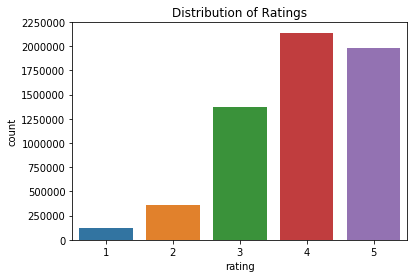

In [23]:
sns.countplot(ratings['rating']).set_title("Distribution of Ratings")

### What is the number of ratings per user (ideally should follow power law)

In [24]:
avg_ratings_user=ratings.groupby(['user_id'])['rating'].count().reset_index().rename(columns={'rating':'#Ratings'})

Text(0.5,1,'Average Number of Rating per user')

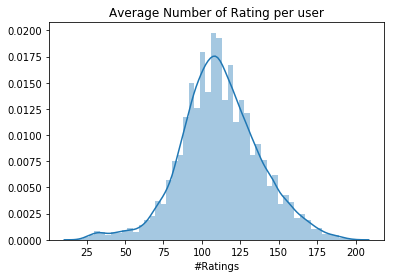

In [27]:
sns.distplot(avg_ratings_user['#Ratings']).set_title("Average Number of Rating per user")

### What are the top 10 highly rated books?

In [41]:
popular_books=books.sort_values(by='average_rating',ascending=False)[['book_id','average_rating','ratings_count','title']]

In [43]:
popular_books[:10]

,book_id,average_rating,ratings_count,title
3627,3628,4.82,28900,The Complete Calvin and Hobbes
3274,3275,4.77,33220,"Harry Potter Boxed Set, Books 1-5 (Harry Potte..."
861,862,4.77,73572,"Words of Radiance (The Stormlight Archive, #2)"
8853,8854,4.76,9081,Mark of the Lion Trilogy
7946,7947,4.76,8953,ESV Study Bible
4482,4483,4.75,22351,It's a Magical World: A Calvin and Hobbes Coll...
6360,6361,4.74,16766,There's Treasure Everywhere: A Calvin and Hobb...
421,422,4.74,190050,"Harry Potter Boxset (Harry Potter, #1-7)"
3752,3753,4.73,24618,"Harry Potter Collection (Harry Potter, #1-6)"
6919,6920,4.73,14597,The Indispensable Calvin and Hobbes


Calvin and Hobbes and Harry Potter Box set seem to be the top 10 most highly rated books

### What books are most read??

In [44]:
most_read=books.sort_values(by='ratings_count',ascending=False)[['book_id','ratings_count','title']]


In [45]:
most_read[:10]

,book_id,ratings_count,title
0,1,4780653,"The Hunger Games (The Hunger Games, #1)"
1,2,4602479,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,3866839,"Twilight (Twilight, #1)"
3,4,3198671,To Kill a Mockingbird
4,5,2683664,The Great Gatsby
5,6,2346404,The Fault in Our Stars
6,7,2071616,The Hobbit
7,8,2044241,The Catcher in the Rye
9,10,2035490,Pride and Prejudice
8,9,2001311,"Angels & Demons (Robert Langdon, #1)"


A popularity based recommender can get list of  books, ordered by either ratings score or number of users who have rated.
The drawback of this model is that it is not personalised. 

The next approach can be to recommends books to users based on the content of the book - for example: if user A likes books that are related to history, we can recommend other history books.
Such kind of recommendation systems are called **Content Based Recommender Systems**

Before, we build content based recommender system, let us look at the other features available in the dataset

### Who are the most popular authors?

1. Author with most votes?
2. Author with highest ratings?

In [63]:
most_votes_author=books.groupby(['authors'])['ratings_count'].mean().reset_index().rename(columns={'ratings_count':'average_number_ratings'})
most_votes_author.sort_values(by='average_number_ratings',ascending=False)

,authors,average_number_ratings
274,"Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-D...",1.972666e+06
1522,"George Orwell, Erich Fromm, Celâl Üster",1.956832e+06
1870,"J.K. Rowling, Mary GrandPré, Rufus Beck",1.832823e+06
1869,"J.K. Rowling, Mary GrandPré",1.671596e+06
1652,Harper Lee,1.668670e+06
4581,"William Shakespeare, Robert Jackson",1.628519e+06
4553,William Golding,1.605019e+06
2542,Kathryn Stockett,1.531753e+06
352,Arthur Golden,1.300209e+06
737,"Charlotte Brontë, Michael Mason",1.198557e+06


There are books authored by more than one author.. 

 There seem to be non-english authors as well. This is because though good reads is english based it gives the author names of noth the translated edition and original edition.

### What factors effect a books rating??

In [69]:
factors=books[['average_rating','ratings_count','work_ratings_count','work_text_reviews_count','books_count','original_publication_year']]

In [71]:
corr=factors.corr()

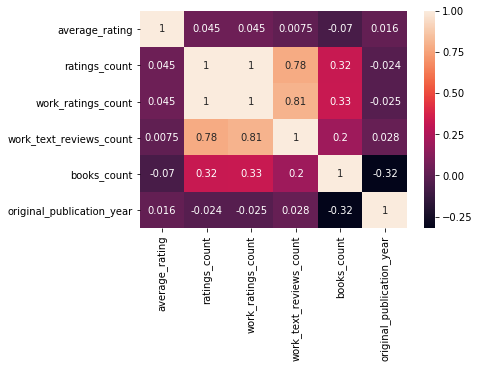

In [83]:
sns.heatmap(corr,annot=True)

There is only a very small correlation between average_rating and ratings_count

Each book may have many editions. goodreads_book_id and best_book_id generally point to the most popular edition of a given book, while goodreads work_id refers to the book in the abstract sense.

You can use the goodreads book and work IDs to create URLs to see the difference:

https://www.goodreads.com/book/show/2767052 https://www.goodreads.com/work/editions/2792775

Note that book_id in ratings.csv and to_read.csv maps to work_id, not to goodreads_book_id. It means that ratings for different editions are aggregated.

### Content Based Recommender System

In contenyt based recommender system, we use the properties of the items to recommend other similar items. In our case, we can use the tags associated with a book to build a contentbased recommender systems

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
5,1,11743,9954
6,1,14017,7169
7,1,5207,6221
8,1,22743,4974
9,1,32989,4364
